In [1]:
include("init_libs.jl")
using LsqFit
using GSL
const all_times = linspace(0, 150, 26)
const plot_xs = linspace(0, 150, 1000)
const ntimes = length(all_times);

In [2]:
params, ratios, uncs = NaCsData.calc_survival("data/na_multi_rabi.csv")
params_total, ratios_total, uncs_total = NaCsData.calc_survival("data/na_multi_rabi_total.csv")
ratios = ratios[:, 2]
uncs = uncs[:, 2]
ratios_total = ratios_total[:, 2]
uncs_total = uncs_total[:, 2];

In [3]:
function get_nth_data(data, n, scale)
    data[((n - 1) * ntimes + 1):(n * ntimes)] ./ scale
end

ratios1 = get_nth_data(ratios, 1, ratios_total[1])
uncs1 = get_nth_data(uncs, 1, ratios_total[1])
ratios2 = get_nth_data(ratios, 2, ratios_total[1])
uncs2 = get_nth_data(uncs, 2, ratios_total[1])
ratios3 = get_nth_data(ratios, 3, ratios_total[1])
uncs3 = get_nth_data(uncs, 3, ratios_total[1])

ratios4 = get_nth_data(ratios, 4, ratios_total[2])
uncs4 = get_nth_data(uncs, 4, ratios_total[2])
ratios5 = get_nth_data(ratios, 5, ratios_total[2])
uncs5 = get_nth_data(uncs, 5, ratios_total[2])
ratios6 = get_nth_data(ratios, 6, ratios_total[2])
uncs6 = get_nth_data(uncs, 6, ratios_total[2]);

In [4]:
function strength(n1, n2, η)
    if n1 < 0 || n2 < 0
        return zero(η)
    end
    # Ref http://journals.aps.org/pra/pdf/10.1103/PhysRevA.20.1521
    # Δn ≡ |n1 - n2|
    # n₋ ≡ min(n1, n2)
    # n₊ ≡ max(n1, n2)
    #   ⟨n1|exp(ikx)|n2⟩
    # = ⟨n1|exp(iη(a + a†))|n2⟩
    # = exp(-η^2 / 2) η^Δn √(γ(n₋ + 1) / γ(n₊ + 1)) L^Δn_n₋(η^2)
    # = exp(-η^2 / 2 + Δn log(η) + lγ(n₋ + 1) / 2 - lγ(n₊ + 1) / 2) L^Δn_n₋(η^2)
    n₋ = min(n1, n2)
    n₊ = max(n1, n2)
    Δn = abs(n1 - n2)
    η² = η * η
    lpre = (-η² + lgamma(n₋ + 1) - lgamma(n₊ + 1)) / 2 + log(η) * Δn
    lag = sf_laguerre_n(n₋, Δn, η²)
    lag * exp(lpre)
end;

In [5]:
function signal_strength(ps, t, η, Δn)
    ns = 0:(length(ps) - 1)
    sum(ps .* (cos.(strength.(ns, ns + Δn, η) .* t).^2))
end;

In [6]:
function get_model(ps_gen, η, Δn)
    function model(x, p)
        ps = ps_gen(p[1])
        p[2] .* (1 .- signal_strength.((ps,), x ./ p[3], η, Δn))
    end
end
function get_ps_gen(nstates)
    function ps_gen(nbar)
        (nbar / (nbar + 1)).^(0:(nstates - 1)) / (nbar + 1)
    end
end;

In [7]:
ps_gen100 = get_ps_gen(100)
model0_100_34 = get_model(ps_gen100, 0.34, 0);

(fit.param,estimate_errors(fit)) = ([4.05417,0.882816,7.59923],[1.22879,0.0422601,0.174594])

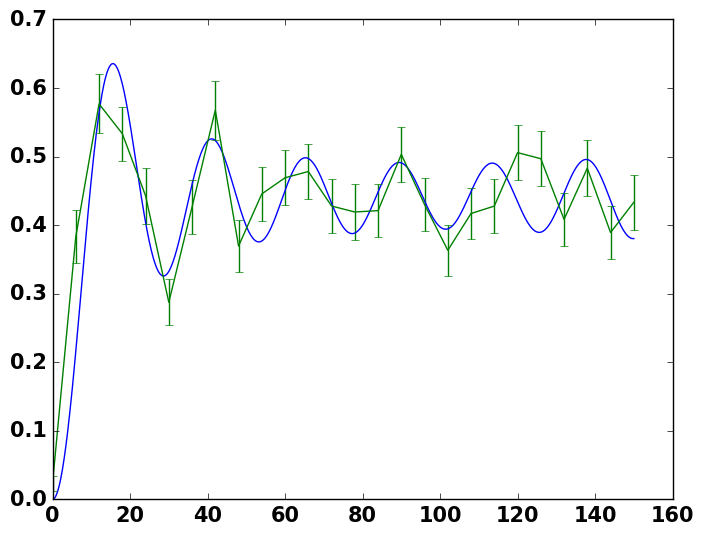

In [8]:
fit = curve_fit(model0_100_34, all_times, ratios1, [4.0, 0.8, 8])
@show fit.param, estimate_errors(fit)
ys = model0_100_34(plot_xs, fit.param)
plot(plot_xs, ys)
errorbar(all_times, ratios1, uncs1);

(fit4.param,estimate_errors(fit4)) = ([2.18365,0.748539,6.75394],[0.839727,0.0457501,0.0927816])

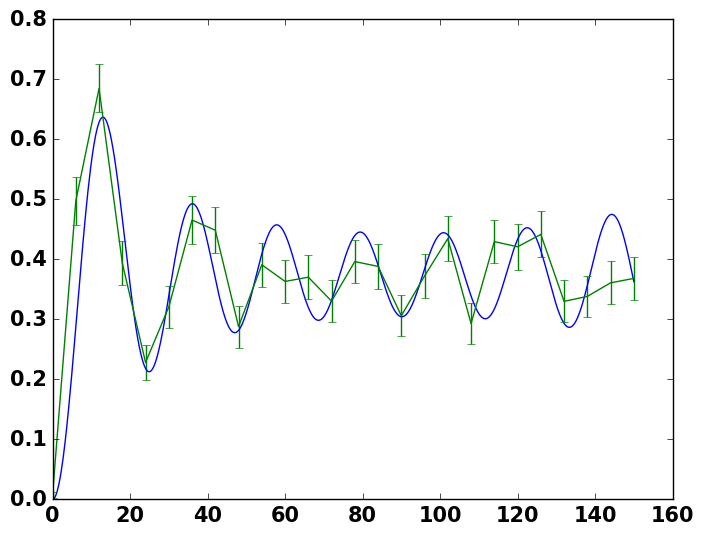

In [9]:
fit4 = curve_fit(model0_100_34, all_times, ratios4, [4.0, 0.8, 8])
@show fit4.param, estimate_errors(fit4)
ys = model0_100_34(plot_xs, fit4.param)
plot(plot_xs, ys)
errorbar(all_times, ratios4, uncs4);